## Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report , precision_score , recall_score 
from sklearn.metrics import f1_score , roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

In [2]:
engine =create_engine('sqlite:///../Data/2023.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-04-05,13.807,4.3,Chile,-27.463719,-70.887772,51.242455,33.810533,37.817714,4.677273,4.773333,4.642857,1
1,2023-04-06,44.638,4.2,Chile,-27.463719,-70.887772,48.829909,29.772400,36.637000,4.659091,4.693333,4.500000,1
2,2023-04-07,60.824,4.1,Chile,-27.463719,-70.887772,47.975136,33.300333,40.759571,4.650000,4.626667,4.485714,1
3,2023-04-08,165.564,4.2,Chile,-27.463719,-70.887772,52.054227,41.382533,59.411571,4.645455,4.593333,4.457143,1
4,2023-03-24,31.107,4.7,Indonesia,-3.327873,123.458295,44.272045,31.903267,34.052571,4.531818,4.526667,4.557143,1


In [4]:
engine =create_engine('sqlite:///../Data/2023_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-04-09,48.522,4.2,Chile,-27.463719,-70.887772,51.302955,43.731533,61.154571,4.581818,4.580000,4.457143,NaN
1,2023-04-10,51.829,4.1,Chile,-27.463719,-70.887772,48.271318,45.453467,61.715429,4.586364,4.433333,4.200000,NaN
2,2023-04-11,91.479,4.3,Chile,-27.463719,-70.887772,49.364318,49.838667,68.094714,4.600000,4.420000,4.200000,NaN
3,2023-04-11,127.051,4.6,Chile,-27.463719,-70.887772,49.866591,57.642067,84.272429,4.604545,4.446667,4.242857,NaN
4,2023-04-11,27.325,4.3,Chile,-27.463719,-70.887772,46.326364,58.797067,81.799143,4.554545,4.433333,4.257143,NaN


In [6]:
df_features.corr()

,depth,mag,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
depth,1.000000,0.326314,0.229313,-0.149750,0.447779,0.470843,0.534422,0.157445,0.166903,0.182508,0.059656
mag,0.326314,1.000000,-0.219399,0.269544,0.193248,0.205807,0.224138,0.543789,0.564025,0.623271,0.330171
latitude,0.229313,-0.219399,1.000000,-0.731114,0.522028,0.490449,0.426564,-0.391670,-0.380449,-0.349500,-0.357385
longitude,-0.149750,0.269544,-0.731114,1.000000,-0.350195,-0.318258,-0.276024,0.478797,0.464487,0.426542,0.594710
depth_avg_22,0.447779,0.193248,0.522028,-0.350195,1.000000,0.956096,0.832927,0.347451,0.340098,0.308498,0.105045
depth_avg_15,0.470843,0.205807,0.490449,-0.318258,0.956096,1.000000,0.878188,0.339361,0.355415,0.330024,0.112632
depth_avg_7,0.534422,0.224138,0.426564,-0.276024,0.832927,0.878188,1.000000,0.294660,0.310738,0.346440,0.104416
mag_avg_22,0.157445,0.543789,-0.391670,0.478797,0.347451,0.339361,0.294660,1.000000,0.970731,0.881475,0.573817
mag_avg_15,0.166903,0.564025,-0.380449,0.464487,0.340098,0.355415,0.310738,0.970731,1.000000,0.915910,0.557512
mag_avg_7,0.182508,0.623271,-0.349500,0.426542,0.308498,0.330024,0.346440,0.881475,0.915910,1.000000,0.514643


In [7]:
features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

In [9]:
X=df_features[features]

In [10]:
X

,depth,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7
0,13.807,51.242455,33.810533,37.817714,4.677273,4.773333,4.642857
1,44.638,48.829909,29.772400,36.637000,4.659091,4.693333,4.500000
2,60.824,47.975136,33.300333,40.759571,4.650000,4.626667,4.485714
3,165.564,52.054227,41.382533,59.411571,4.645455,4.593333,4.457143
4,31.107,44.272045,31.903267,34.052571,4.531818,4.526667,4.557143
...,...,...,...,...,...,...,...
10133,8.900,6.081818,6.126667,8.885714,0.672727,0.813333,1.028571
10134,11.300,6.000000,6.553333,9.171429,0.677273,0.933333,1.185714
10135,6.400,5.813636,6.753333,8.728571,0.663636,0.940000,1.142857
10136,6.400,5.795455,6.406667,8.357143,0.659091,0.840000,1.014286


In [11]:
y=df_features["mag_outcome"]

In [12]:
y

0        1
1        1
2        1
3        1
4        1
        ..
10133    0
10134    0
10135    0
10136    0
10137    0
Name: mag_outcome, Length: 10138, dtype: int64

In [13]:
y_df=pd.DataFrame(y)

## Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)


Models used for training:

- Adaboost classifier with DecisionTree
- Adaboost classifier with RandomForest
- GridSearch CV for hyper parameter tunning

Model for deployment/testing:

- XgBoost with Hyperparameters set from above models


## AdaBoost 

#### AdaBoost + Decsion Tree Classifier

In [15]:
param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

In [16]:
# base estimator
tree = DecisionTreeClassifier()

In [17]:
# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [18]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [19]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [20]:
pred_ABC=grid_search_ABC.predict(X_test)

In [21]:
print("Train Accuracy:",grid_search_ABC.score(X_train, y_train)*100,"%")
print("Test Accuracy:",grid_search_ABC.score(X_test, y_test)*100,"%")
print("Precision Score: ",precision_score(y_test, pred_ABC))
print("Recall Score: ",recall_score(y_test, pred_ABC)) 
print("F1 Score: ",f1_score(y_test, pred_ABC))

Train Accuracy: 99.95919378579651 %
Test Accuracy: 99.5808353192023 %
Precision Score:  0.8444444444444444
Recall Score:  0.5671641791044776
F1 Score:  0.6785714285714286


In [22]:
print("Confusion Matrix: ")
cm_abc=confusion_matrix(y_test, pred_ABC)
print(cm_abc)

Confusion Matrix: 
[[2968    7]
 [  29   38]]


AUC: 0.7824


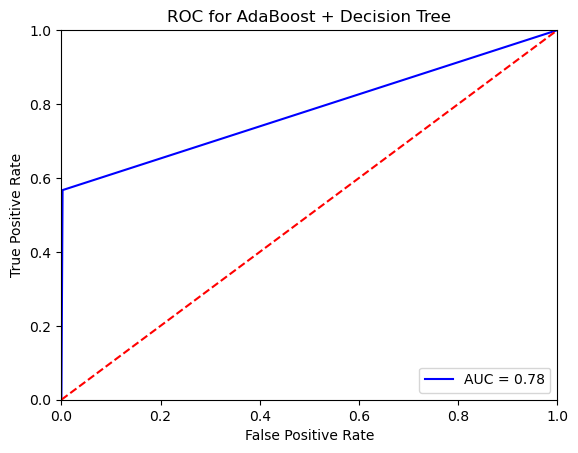

In [23]:
fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('ROC for AdaBoost + Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### AdaBoost with Random Forest Classifier

In [24]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

In [25]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [26]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [27]:
pred=CV_rfc.predict(X_test)

In [28]:
print("Train Accuracy:",CV_rfc.score(X_train, y_train)*100,"%")
print("Test Accuracy:",CV_rfc.score(X_test, y_test)*100,"%")
print("Precision Score: ",precision_score(y_test, pred))
print("Recall Score: ",recall_score(y_test, pred)) 
print("F1 Score: ",f1_score(y_test, pred))

Train Accuracy: 100.0 %
Test Accuracy: 99.0138067061144 %
Precision Score:  0.9111111111111111
Recall Score:  0.6119402985074627
F1 Score:  0.7321428571428571


In [29]:
print("Confusion Matrix: ")
cm_abc_rf=confusion_matrix(y_test, pred)
print(cm_abc_rf)

Confusion Matrix: 
[[2971    4]
 [  26   41]]


AUC: 0.8053


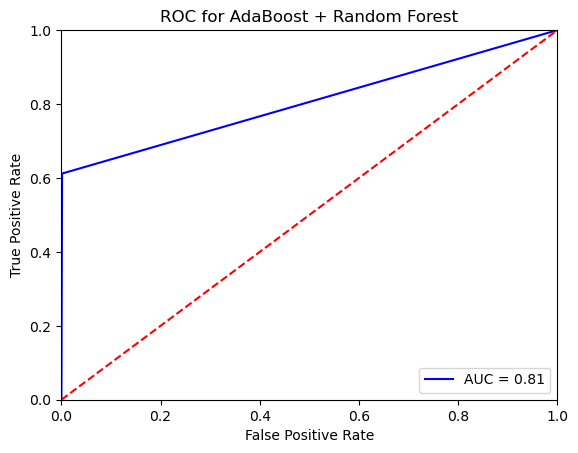

In [30]:
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('ROC for AdaBoost + Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XgBoost

In [31]:
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

In [32]:
param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations 

In [33]:
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

[19:22:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [34]:
print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

0.996558384547849
AUC: 0.9966


In [35]:
ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int) 

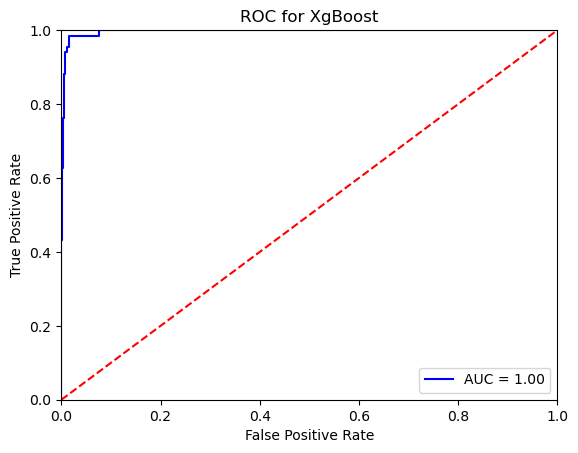

In [36]:
plt.title('ROC for XgBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

Confusion Matrix: 
 [[2967    8]
 [  23   44]]

Recall 'TP/TP+FN' =  0.6567164179104478


### Prediction on df_predict data frame

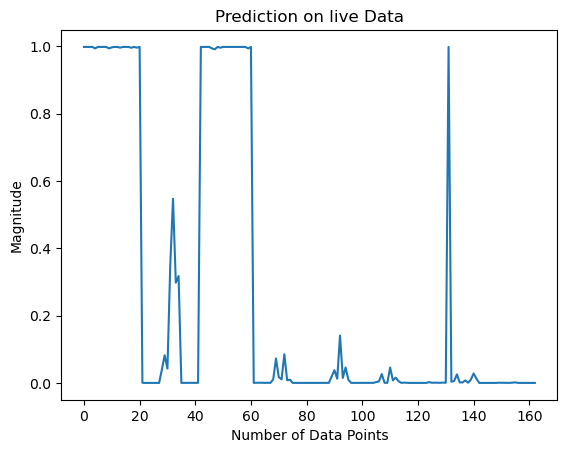

In [38]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.title("Prediction on live Data")
plt.ylabel("Magnitude")
plt.xlabel("Number of Data Points")
plt.plot(preds)
plt.show()

## Prediction

In [39]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
72,2023-04-22,Hawaii,19.285559,-155.401077,0.000419
73,2023-04-22,Indonesia,-3.327873,123.458295,0.995708
74,2023-04-22,Japan,36.045604,138.804464,0.997941
75,2023-04-22,Puerto Rico,18.065986,-66.844636,0.310475
76,2023-04-22,Turkey,37.879500,36.691996,0.012727


In [40]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str)]))
days.sort()

In [41]:
days

['2023-04-07',
 '2023-04-08',
 '2023-04-11',
 '2023-04-12',
 '2023-04-13',
 '2023-04-14',
 '2023-04-15',
 '2023-04-16',
 '2023-04-17',
 '2023-04-18',
 '2023-04-19',
 '2023-04-20',
 '2023-04-21',
 '2023-04-22']

In [42]:
# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2023-04-11'

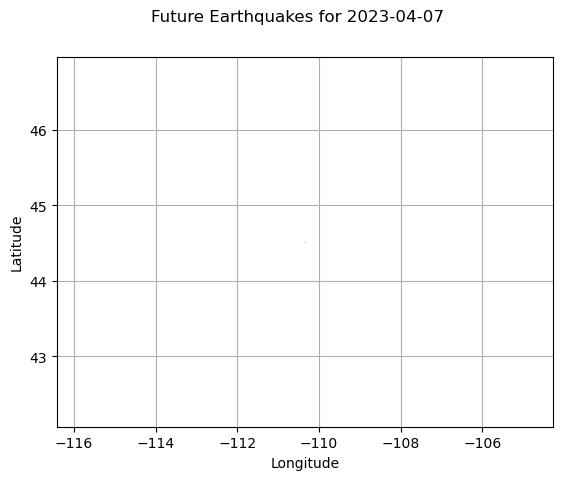

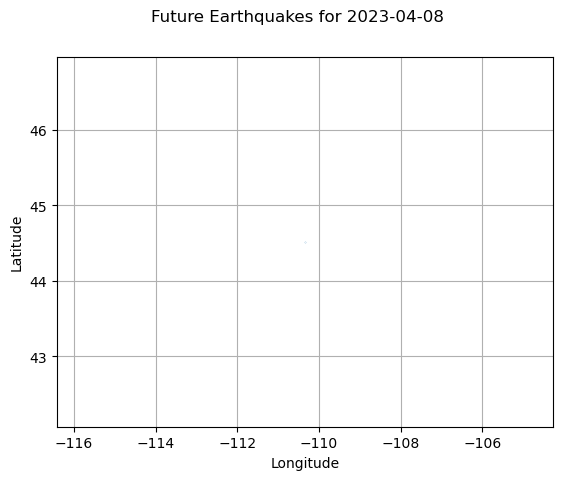

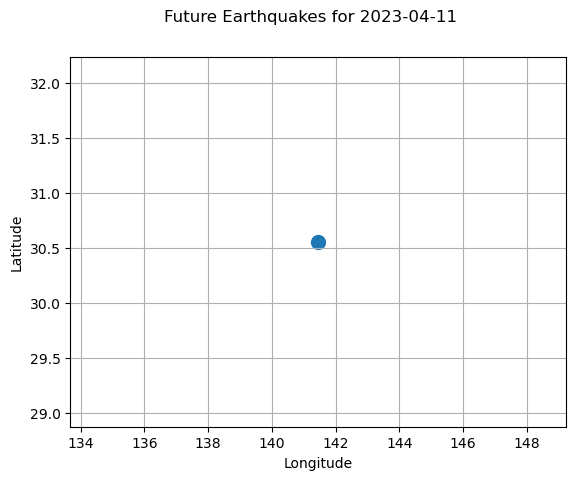

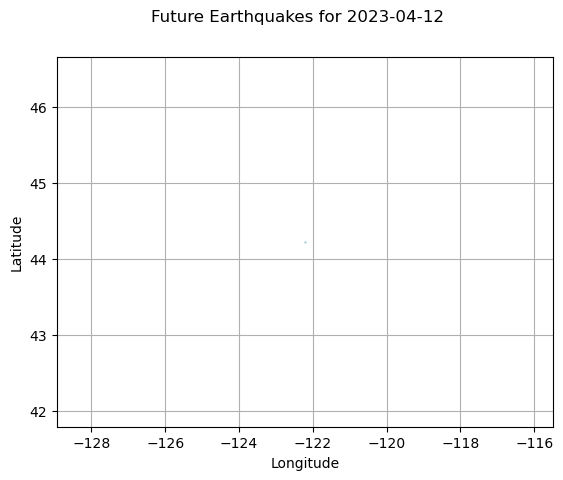

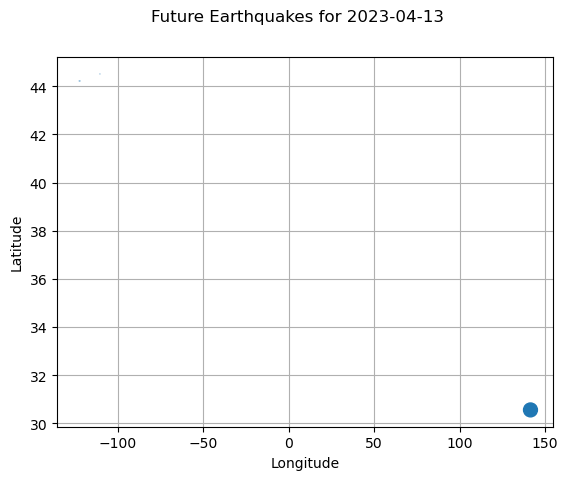

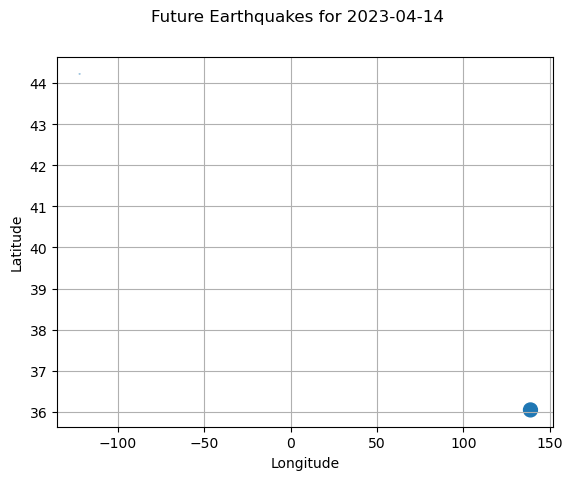

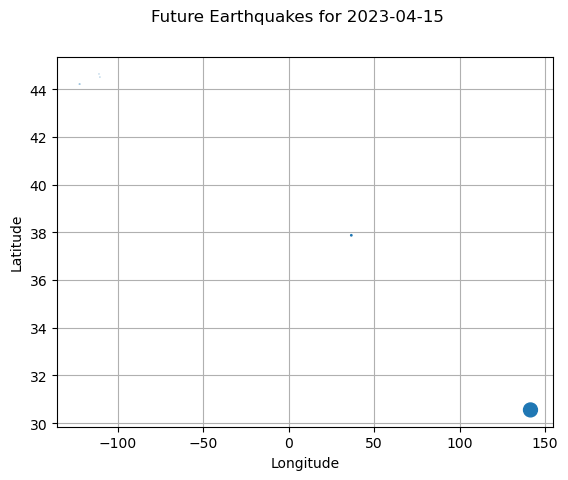

In [43]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()